# Initialisation

In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image

from keras import layers
from keras.applications import mobilenet_v2
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import seaborn as sns

import time
import pathlib

from ultralytics import YOLO

2025-12-12 17:03:10.194790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765544590.215576  131810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765544590.225601  131810 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765544590.383898  131810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765544590.383925  131810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765544590.383928  131810 computation_placer.cc:177] computation placer alr

In [2]:
keras.version()

'3.6.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Constants
DATA_SRC = 'garbage_classification/'
MODEL_PATH = "./garbage_classification.keras"
FINETUNED_MODEL_PATH = "./garbage_classification_finetuned.keras"
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

BATCH_SIZE = 32
EPOCHS = 20
SEED = 123

# Model Preparation

In [5]:
# Create the dataset (ds)
garbage_directory = pathlib.Path(DATA_SRC)
ds = image_dataset_from_directory(
    directory=garbage_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
)

Found 15515 files belonging to 12 classes.


I0000 00:00:1765544596.036180  131810 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5427 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [6]:
classes = ds.class_names
len_classes = len(classes)
print(f"Detected classes: {classes}\nClass size: {len_classes}")

Detected classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Class size: 12


In [7]:
# Apply the split to the dataset. 
total_batches = tf.data.experimental.cardinality(ds).numpy()
train_size = int(total_batches * TRAIN_SIZE)
val_size = int(total_batches * VAL_SIZE)
test_size = total_batches - train_size - val_size

if train_size + val_size + test_size != total_batches:
    print("ERROR: Invalid split sizes.")
    exit(1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")
print(f"Total batches found: {total_batches}")

Train size: 388
Validation size: 48
Test size: 49
Total batches found: 485


In [8]:
# Split the dataset into train, validation and test. Each taking their respective sizes
train_ds = ds.take(train_size)
leftover_ds = ds.skip(train_size)
val_ds = leftover_ds.take(val_size)
test_ds = leftover_ds.skip(val_size)

print(f"Train size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_ds).numpy()}")

Train size: 388
Validation size: 48
Test size: 49


## Balancing Class Weights

In [9]:
# VERY IMPORTANT STEP! This ensures reliability since our dataset is not balanced. 
all_labels = []

for image, label in train_ds.unbatch():
    all_labels.append(label.numpy())

y_train_one_hot = np.array(all_labels)
y_train_int = np.argmax(y_train_one_hot, axis=1)

print(f"Total training samples processed: {len(y_train_int)}")

Total training samples processed: 12416


2025-12-12 17:03:19.733767: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
classes_np = np.arange(len_classes)

# Calculate the weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes_np,
    y=y_train_int
)

class_weight_dict = dict(zip(classes_np, class_weights))

print("Weight distribution for the following dataset:")
for class_index, weight in class_weight_dict.items():
    print(f"Category {class_index}  ({classes[class_index]}) weight: {weight:.3f}")

Weight distribution for the following dataset:
Category 0  (battery) weight: 1.376
Category 1  (biological) weight: 1.313
Category 2  (brown-glass) weight: 2.099
Category 3  (cardboard) weight: 1.439
Category 4  (clothes) weight: 0.242
Category 5  (green-glass) weight: 2.037
Category 6  (metal) weight: 1.653
Category 7  (paper) weight: 1.250
Category 8  (plastic) weight: 1.535
Category 9  (shoes) weight: 0.655
Category 10  (trash) weight: 1.905
Category 11  (white-glass) weight: 1.635


In [11]:
# Alter the image in various ways so that the model is more robust
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.25, 0.25),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.2)
])

In [12]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=5, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

# Plateau will help to optimize the training  passively as the epochs go by.
plateau = ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

# This will actively monitor the learning process and save the best model.
checkpoint = ModelCheckpoint("garbage_classification_checkpoint.keras", monitor='val_categorical_accuracy', save_best_only=True,mode='max',verbose=1)

callbacks = [early_stop, plateau, checkpoint]

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
def augment_ds(ds, augment=False):
    if augment:
        ds = ds.map(lambda a, b: (data_augmentation(a, training=True), b),
        num_parallel_calls=AUTOTUNE
        
        )
    ds = ds.cache()
    if augment:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [14]:
# We want to augment the training dataset only
# Helps model recognize variations of the image
train_ds = augment_ds(train_ds, augment=True)
val_ds = augment_ds(val_ds, augment=False)
test_ds = augment_ds(test_ds, augment=False)

## Preprocess Function

In [15]:
# Preprocess the image, resize and normalize
def preprocess_model_input(img):
    return mobilenet_v2.preprocess_input(img)

# Model Training

In [16]:
# Here we use transfer learning
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
model.add(Lambda(preprocess_model_input))
model.add(mobile_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(len_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,644 (10.03 MB)

 Trainable params: 370,764 (1.41 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

model.save(MODEL_PATH)

Epoch 1/20


2025-12-12 17:03:34.601835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 261 of 1000
2025-12-12 17:03:39.419281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1765544619.523154  132033 service.cc:152] XLA service 0x7f84c80118a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765544619.524226  132033 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-12-12 17:03:39.878265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765544621.548860  132033 cuda_dnn.cc:529] Loaded cuDNN version 91501
2025-12-12 17:03:43.223392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.3791 - loss: 2.0633
Epoch 1: val_categorical_accuracy improved from -inf to 0.87826, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 70s 76ms/step - categorical_accuracy: 0.3795 - loss: 2.0620 - val_categorical_accuracy: 0.8783 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 2/20
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7290 - loss: 0.9387
Epoch 2: val_categorical_accuracy improved from 0.87826 to 0.90430, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - categorical_accuracy: 0.7291 - loss: 0.9386 - val_categorical_accuracy: 0.9043 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 3/20
 12/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - categorical_accuracy: 0.7221 - loss: 0.8405

2025-12-12 17:04:40.405217: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269376 bytes after encountering the first element of size 19269376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.7678 - loss: 0.7903
Epoch 3: val_categorical_accuracy improved from 0.90430 to 0.91927, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - categorical_accuracy: 0.7678 - loss: 0.7903 - val_categorical_accuracy: 0.9193 - val_loss: 0.2662 - learning_rate: 0.0010
Epoch 4/20
385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.8038 - loss: 0.6878
Epoch 4: val_categorical_accuracy improved from 0.91927 to 0.92188, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.8038 - loss: 0.6879 - val_categorical_accuracy: 0.9219 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.8213 - loss: 0.6229
Epoch 5: val_categorical_accuracy improved from 0.92188 to 0.92578, saving model to garbage_classification_checkpoint.keras
388/388 ━━

# Fine-Tuning

In [18]:
def freeze_model(model, layers_to_unfreeze):
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-5),
        metrics=['categorical_accuracy']
    )
    return model

In [19]:
# Unfreeze x layers
new_model = freeze_model(model, 20)
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,644 (10.03 MB)

 Trainable params: 1,576,844 (6.02 MB)

 Non-trainable params: 1,052,800 (4.02 MB)

In [20]:
# Train
history_tuned = new_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

model.save(FINETUNED_MODEL_PATH)

Epoch 1/20


2025-12-12 17:08:05.230920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269376 bytes after encountering the first element of size 19269376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-12 17:08:08.337738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7447', 12 bytes spill stores, 16 bytes spill loads



386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.8167 - loss: 0.5753
Epoch 1: val_categorical_accuracy did not improve from 0.93359
388/388 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - categorical_accuracy: 0.8167 - loss: 0.5753 - val_categorical_accuracy: 0.9303 - val_loss: 0.2399 - learning_rate: 1.0000e-05
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8453 - loss: 0.4529
Epoch 2: val_categorical_accuracy did not improve from 0.93359
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - categorical_accuracy: 0.8453 - loss: 0.4529 - val_categorical_accuracy: 0.9323 - val_loss: 0.2391 - learning_rate: 1.0000e-05
Epoch 3/20
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8618 - loss: 0.4155
Epoch 3: val_categorical_accuracy did not improve from 0.93359
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - categorical_accuracy: 0.8618 - loss: 0.4155 - val_categorical_accuracy: 0.9284 - val_loss: 0.2451 - learning_rate: 1.0000e-05
Epoch 4/20
 10

2025-12-12 17:08:50.734337: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269376 bytes after encountering the first element of size 19269376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8739 - loss: 0.3608
Epoch 4: val_categorical_accuracy did not improve from 0.93359
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - categorical_accuracy: 0.8739 - loss: 0.3608 - val_categorical_accuracy: 0.9271 - val_loss: 0.2421 - learning_rate: 1.0000e-05
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8768 - loss: 0.3283
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 5: val_categorical_accuracy did not improve from 0.93359
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - categorical_accuracy: 0.8769 - loss: 0.3283 - val_categorical_accuracy: 0.9284 - val_loss: 0.2343 - learning_rate: 1.0000e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


# Model Loading

In [24]:
# If you would like to reload the model, run all the code in Initialisation and Model Preparation. 
# This will load the test generator and the model
try:
    keras.config.enable_unsafe_deserialization()
    model = load_model(MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
    finetuned = load_model(FINETUNED_MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
except Exception as e:
    print("ERROR: Model has not been loaded.", e)
    exit(1)

# Model Validation

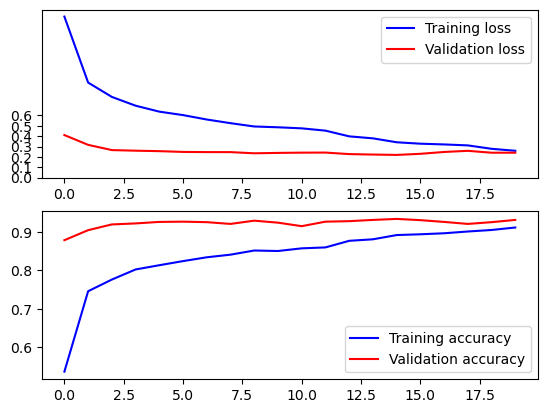

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.show()

In [25]:
def get_loss_and_accuracy(model, test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=1)
    return loss, accuracy

In [26]:
loss, accuracy = get_loss_and_accuracy(model, test_ds)
tuned_loss, tuned_accuracy = get_loss_and_accuracy(finetuned, test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

print(f"Test Loss: {tuned_loss:.4f}")
print(f"Test Accuracy: {tuned_accuracy*100:.2f}%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - categorical_accuracy: 0.9311 - loss: 0.2236
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - categorical_accuracy: 0.9230 - loss: 0.2472
Test Loss: 0.2471
Test Accuracy: 92.45%
Test Loss: 0.2737
Test Accuracy: 92.00%


In [27]:
def get_predictions(model, test_ds):
    y_pred_probs = model.predict(test_ds)

    true_labels = []

    for test_images, test_labels in test_ds:
        true_labels.extend(tf.argmax(test_labels, axis=1).numpy())

    pred_labels = np.argmax(y_pred_probs, axis=1)

    y_true = true_labels
    y_pred = pred_labels

    return y_true, y_pred

In [42]:
def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=classes))

In [43]:
y_true, y_pred = get_predictions(model, test_ds)
print_classification_report(y_true, y_pred)

tuned_y_true, tuned_y_pred = get_predictions(finetuned, test_ds)
print_classification_report(tuned_y_true, tuned_y_pred)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

     battery       0.94      0.95      0.95       101
  biological       0.97      0.96      0.97       108
 brown-glass       0.89      0.83      0.86        59
   cardboard       0.91      0.90      0.91        96
     clothes       1.00      0.99      0.99       531
 green-glass       0.90      0.90      0.90        63
       metal       0.68      0.85      0.76        61
       paper       0.86      0.84      0.85       109
     plastic       0.76      0.76      0.76        97
       shoes       0.98      0.97      0.98       187
       trash       0.90      0.94      0.92        81
 white-glass       0.80      0.73      0.76        70

    accuracy                           0.92      1563
   macro avg       0.88      0.89      0.88      1563
weighted avg       0.93      0.92      0.93      1563

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

<Axes: >

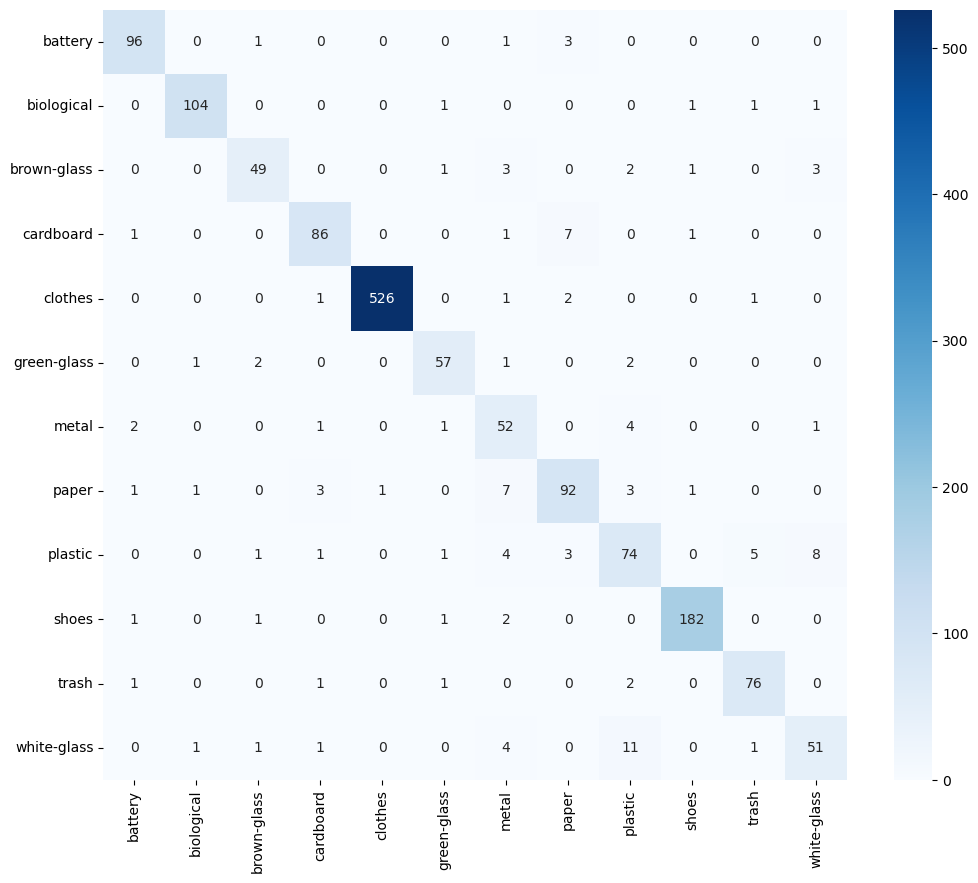

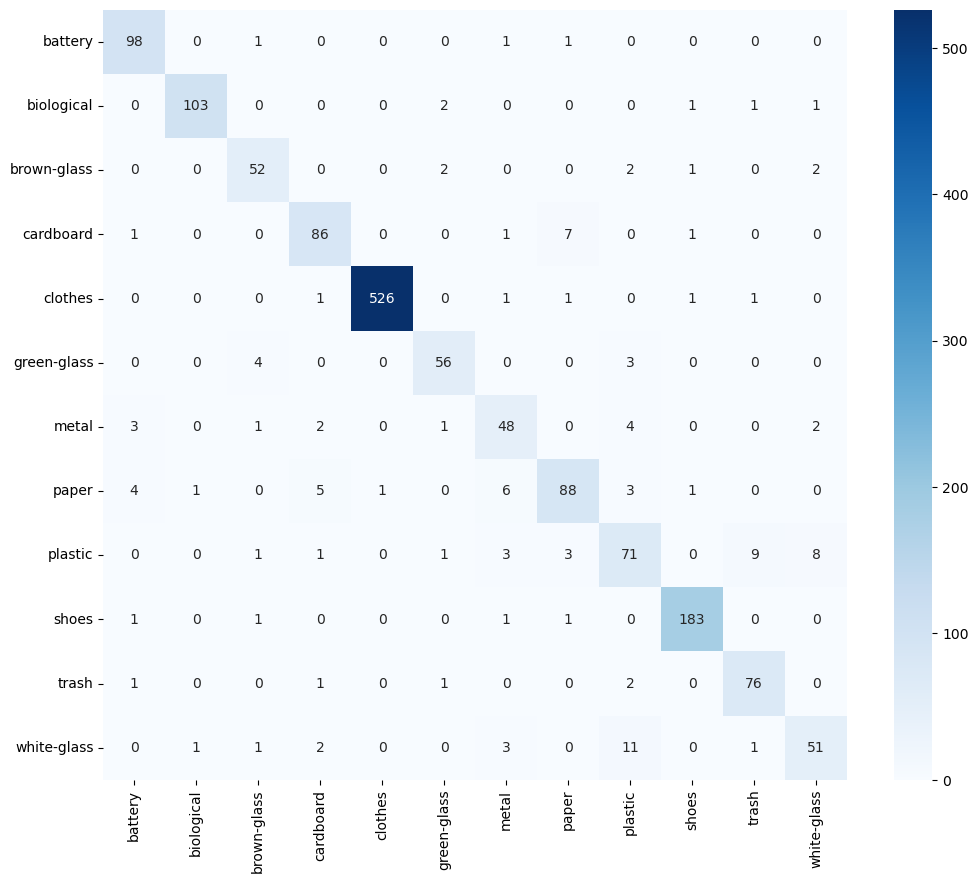

In [30]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

cm2 = confusion_matrix(tuned_y_true, tuned_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm2, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

# Implementation with OpenCV

In [31]:
CAM_INDEX = 0
video_stream = cv2.VideoCapture(CAM_INDEX)
video_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
video_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
if not video_stream.isOpened():
    print("ERROR: Could not open camera.")
    exit(1)
print("Press 'ESC' to quit")

CONFIDENCE_THRESHOLD = 0.65
EPSILON = 1e-10
yolo = YOLO("yolov10s.pt")

while True:
    # Capture frame-by-frame
    ret, frame = video_stream.read()

    

    if not ret:
        print("ERROR: Can't receive frame.")
        break

    objects = yolo.predict(frame,verbose=False,imgsz=480,conf=0.30)

    for o in objects:
        for box in o.boxes:
            if yolo.names[int(box.cls[0])] == "person":
                continue
            
            x1,y1,x2,y2 = box.xyxy[0].cpu().numpy().astype(int)

            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

            cropped_dims = frame[y1:y2, x1:x2]

            if cropped_dims.size > 0:
                cropped_resized = cv2.resize(cropped_dims, IMG_SIZE)
                cropped_rgb_pixels = cv2.cvtColor(cropped_resized, cv2.COLOR_BGR2RGB)
                batch = np.expand_dims(cropped_rgb_pixels, axis=0)
                
                models_prediction = model.predict(batch, verbose=0)
    
                models_prediction_class_idx = np.argmax(models_prediction[0])
                models_prediction_class_name = classes[models_prediction_class_idx]
                confidence = models_prediction[0][models_prediction_class_idx]
                
                entropy = np.sum(
                    models_prediction[0] * np.log(models_prediction[0] + EPSILON))
                max_e = np.log(len_classes)
                normal_entropy = entropy / max_e 

                is_confident = (
                    confidence >= CONFIDENCE_THRESHOLD and 
                    normal_entropy <= 0.7
                )
                
                if is_confident:
                    text = f"{models_prediction_class_name} ({confidence * 100:.2f})%"
                else:
                    text = "UNKNOWN"
                cv2.putText(frame, text, (x1,y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2 )

  
    cv2.imshow("Garbage Classification", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        print("Exiting the program...")
        break
    elif key == ord("s"):
        print("Saving the image...")
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"image_{models_prediction_class_name}_{timestamp}.jpg"
        cv2.imwrite(filename, frame)
        

# When everything done, release the capture
video_stream.release()
cv2.destroyAllWindows()
print("Exiting the program...")

[ WARN:0@428.113] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index


ERROR: Could not open camera.
Press 'ESC' to quit
ERROR: Can't receive frame.
Exiting the program...


In [72]:
CONFIDENCE_THRESHOLD = 0.1
EPSILON = 1e-10
yolo = YOLO("yolov10n.pt")

# --- 1. Load the Image ---
image_path = 'image.png'
frame = cv2.imread(image_path)

if frame is None:
    print(f"ERROR: Could not open or find the image: {image_path}")
    exit(1)

print("Processing image...")

# --- 2. Process the Image (No Loop Needed) ---

# Run YOLO prediction on the single frame
objects = yolo.predict(frame, verbose=False, imgsz=480, conf=0.30)

for o in objects:
    for box in o.boxes:

        # Skip detection if it is a person
        if yolo.names[int(box.cls[0])] == "person":
            continue
        
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

        # Draw the bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Crop the object
        cropped_dims = frame[y1:y2, x1:x2]

        if cropped_dims.size > 0:
            # Prepare input for secondary classification model
            cropped_resized = cv2.resize(cropped_dims, IMG_SIZE)
            cropped_rgb_pixels = cv2.cvtColor(cropped_resized, cv2.COLOR_BGR2RGB)
            batch = np.expand_dims(cropped_rgb_pixels, axis=0)
            
            # Predict
            models_prediction = model.predict(batch, verbose=0)

            # Analyze prediction results
            models_prediction_class_idx = np.argmax(models_prediction[0])
            models_prediction_class_name = classes[models_prediction_class_idx]
            confidence = models_prediction[0][models_prediction_class_idx]
            
            # Calculate Entropy
            entropy = np.sum(
                models_prediction[0] * np.log(models_prediction[0] + EPSILON))
            max_e = np.log(len_classes)
            normal_entropy = entropy / max_e 

            # Determine confidence
            is_confident = (
                confidence >= CONFIDENCE_THRESHOLD and 
                normal_entropy <= 0.7
            )
            
            if is_confident:
                text = f"{models_prediction_class_name} ({confidence * 100:.2f})%"
            else:
                text = "UNKNOWN"
            
            # Draw label
            cv2.putText(frame, text, (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        
# --- 3. Display Results ---
cv2.imshow("Garbage Classification", frame)
print("Press 'S' to save the result, or any other key to exit.")

# Wait indefinitely (0) for a key press, instead of 1ms
key = cv2.waitKey(0) & 0xFF

if key == ord("s"):
    print("Saving the image...")
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    # Note: If multiple objects were detected, this uses the name of the *last* detected object
    # You might want to change this to a generic name or list of names
    filename = f"result_{timestamp}.jpg" 
    cv2.imwrite(filename, frame)
    print(f"Saved as {filename}")

cv2.destroyAllWindows()
print("Exiting the program...")

Processing image...
Press 'S' to save the result, or any other key to exit.
Saving the image...
Saved as result_20251212-182303.jpg
Exiting the program...
